# Lectura y Análisis

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator

## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [33]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file
    file_key = file.replace(".csv", "")  # Remove .csv extension for index
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        
        dataframes[file_key] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [34]:
# Read the CSV files
directory = "data/"
cristianos_openmetoe_arpege = "openmeteo_cristianos_arpege.csv"
cristianos_openmetoe_icon = "openmeteo_cristianos_icon.csv"

cristianos_grafcan = "grafcan_cristianos.csv"

#########
# Dates #
#########
start_date = "2023-03-01"
end_date = "2025-02-28"

data_files = [cristianos_openmetoe_arpege,
              cristianos_openmetoe_icon,
              cristianos_grafcan]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing openmeteo_cristianos_arpege.csv...
Processing openmeteo_cristianos_icon.csv...
Processing grafcan_cristianos.csv...


## Visualización

In [35]:
def plot_datasets(datasets, column):
    """
    Plot a specific column from each dataset (given as a list of filenames)
    for all common years.
    
    Parameters:
        datasets (list): List of dataset filenames (e.g., ['file1.csv', 'file2.csv', ...]).
        column (str): The column name to plot from each dataset.
    """
    # Remove .csv extension if present and check if each dataset is loaded
    dataset_names = [name.replace(".csv", "") for name in datasets]
    for name in dataset_names:
        if name not in dataframes:
            print(f"Dataset '{name}' is not loaded.")
            return

    # Retrieve the dataframes
    dfs = [dataframes[name] for name in dataset_names]

    # Align all dataframes on their timestamps by concatenating on axis=1 (inner join ensures common timestamps)
    # Using keys creates a hierarchical column index: top level is dataset name, lower level is the original columns.
    combined = pd.concat(dfs, axis=1, join='inner', keys=dataset_names)
    
    # Ensure the indicated column exists in every dataset
    for name in dataset_names:
        if column not in combined[name].columns:
            print(f"Column '{column}' not found in dataset '{name}'.")
            return

    # Get all common years from the combined index
    common_years = combined.index.year.unique()
    
    # Plot the indicated column for each dataset by year
    for year in common_years:
        df_year = combined[combined.index.year == year]
        plt.figure(figsize=(10, 6))
        for name in dataset_names:
            plt.plot(df_year.index, df_year[name][column],
                     label=f"{name}", linestyle='-', alpha=0.7)
        plt.title(f'Comparison Plot - Column "{column}" - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()


### OpenMeteo

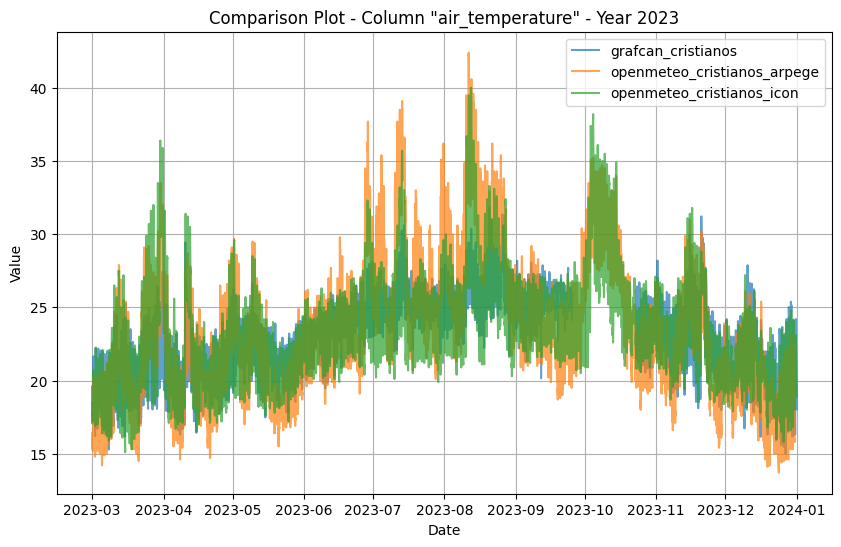

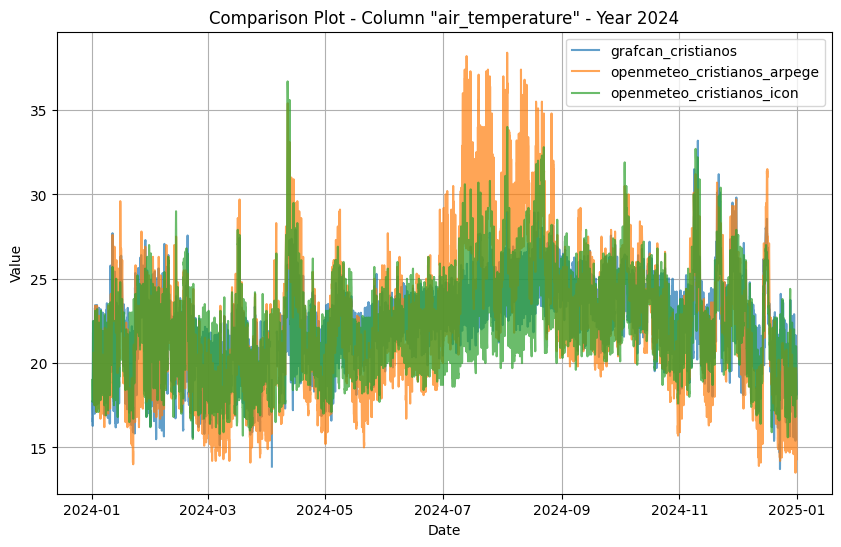

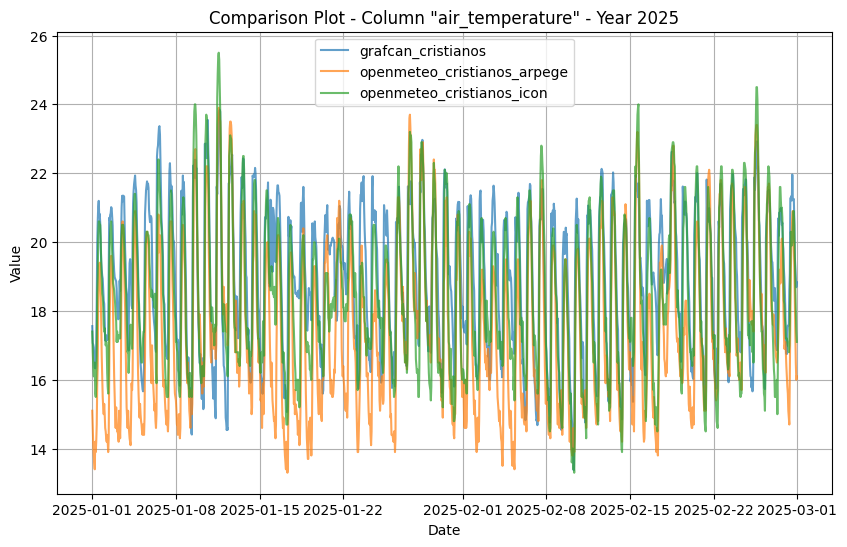

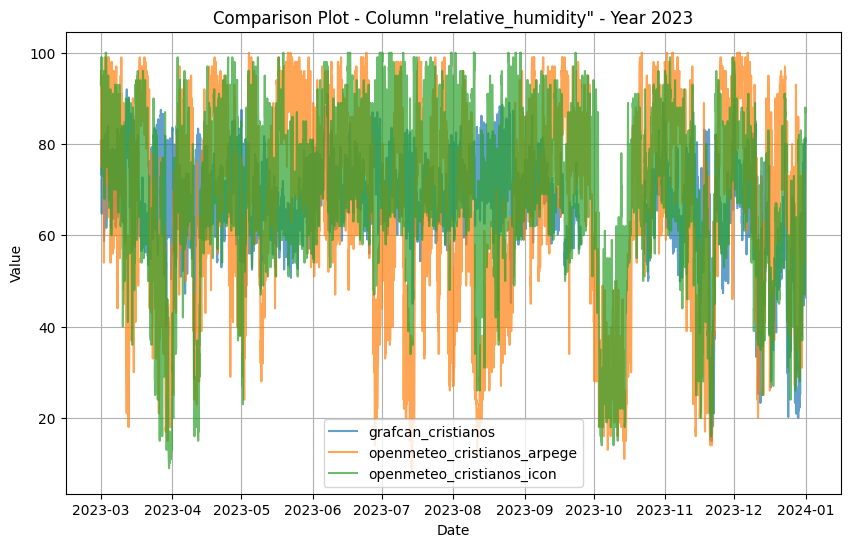

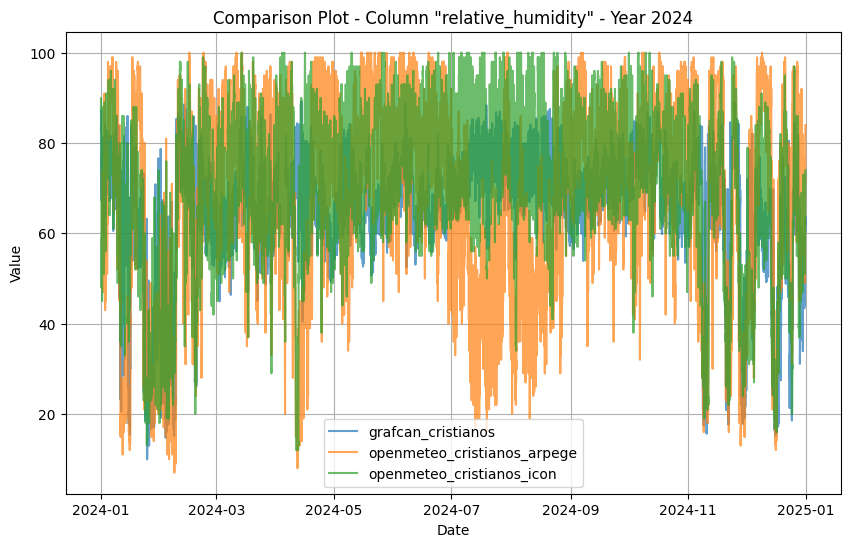

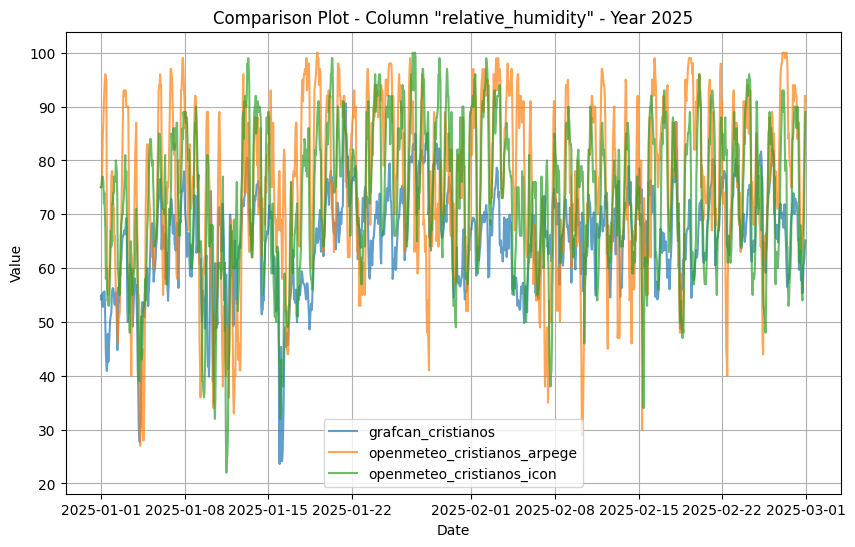

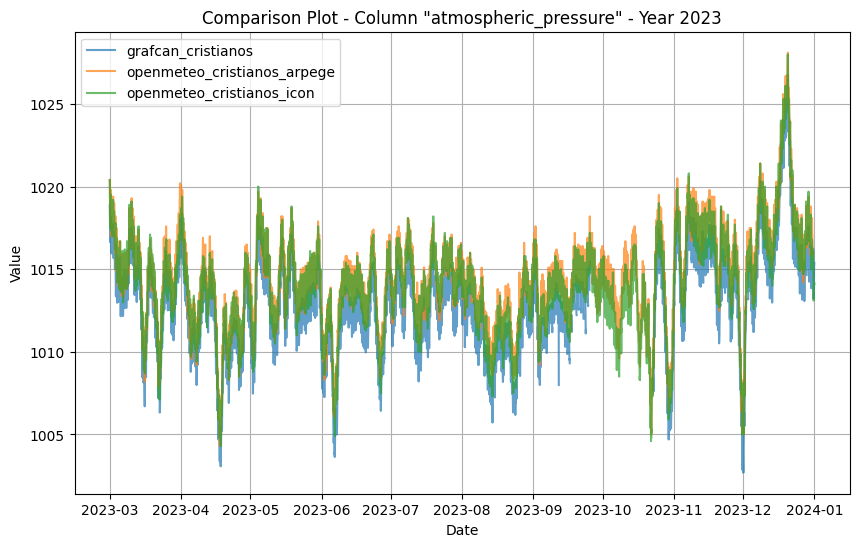

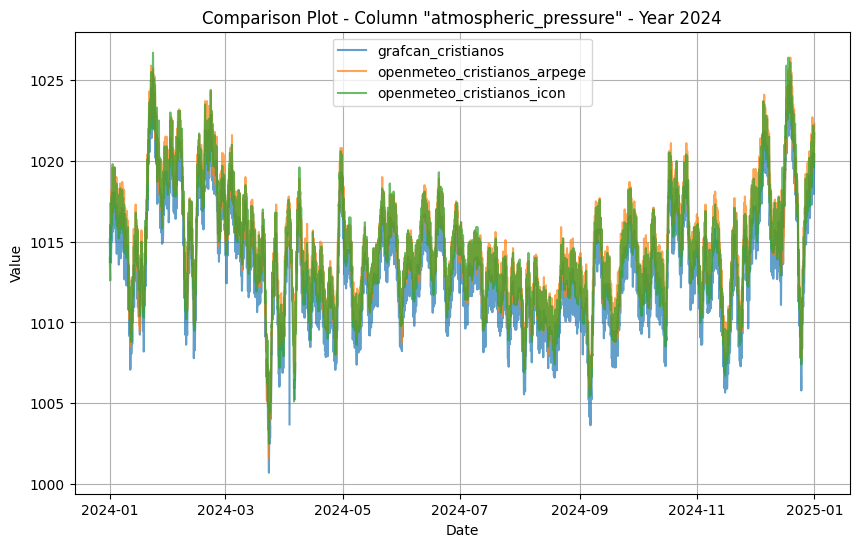

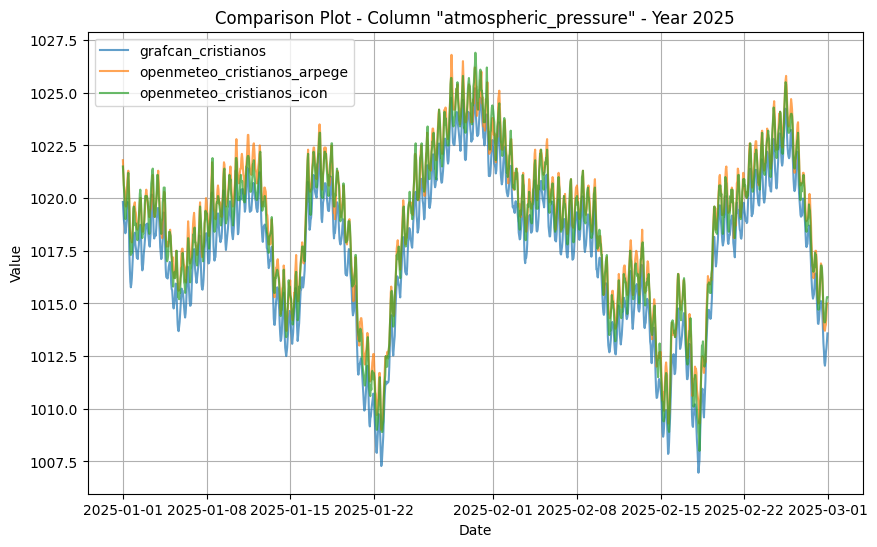

In [36]:
plot_datasets([cristianos_grafcan, cristianos_openmetoe_arpege, cristianos_openmetoe_icon], "air_temperature")
plot_datasets([cristianos_grafcan, cristianos_openmetoe_arpege, cristianos_openmetoe_icon], "relative_humidity")
plot_datasets([cristianos_grafcan, cristianos_openmetoe_arpege, cristianos_openmetoe_icon], "atmospheric_pressure")

## Horas faltantes

In [37]:
    
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours)
    else:
        print(f"No missing hours in {file_key} after resampling.")

Missing hours in openmeteo_cristianos_arpege after resampling:
DatetimeIndex(['2023-12-31 07:00:00+00:00', '2023-12-31 08:00:00+00:00',
               '2023-12-31 09:00:00+00:00', '2023-12-31 10:00:00+00:00',
               '2023-12-31 11:00:00+00:00', '2023-12-31 12:00:00+00:00',
               '2023-12-31 13:00:00+00:00', '2023-12-31 14:00:00+00:00',
               '2023-12-31 15:00:00+00:00', '2023-12-31 16:00:00+00:00',
               '2023-12-31 17:00:00+00:00', '2023-12-31 18:00:00+00:00',
               '2023-12-31 19:00:00+00:00', '2023-12-31 20:00:00+00:00',
               '2023-12-31 21:00:00+00:00', '2023-12-31 22:00:00+00:00',
               '2023-12-31 23:00:00+00:00', '2024-01-01 00:00:00+00:00',
               '2024-01-01 01:00:00+00:00', '2024-01-01 02:00:00+00:00',
               '2024-01-01 03:00:00+00:00', '2024-01-01 04:00:00+00:00',
               '2024-01-01 05:00:00+00:00', '2024-01-01 06:00:00+00:00',
               '2024-01-01 07:00:00+00:00', '2024-01-01 08:00

### Manejo Horas faltantes

In [38]:
# Cubic Spline Interpolation Algorithm

def cubic_spline_interpolation(df):
 # Convert datetime index to a numeric format (Unix timestamp in seconds)
    numeric_index = df.index.astype(np.int64) // 10**9

    # Iterate over each feature column and apply cubic spline interpolation
    for col in df.columns:
        valid_mask = ~df[col].isna()
        # Check if there are enough valid points for interpolation
        if valid_mask.sum() >= 2:

            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)

            #cs = CubicSpline(numeric_index[valid_mask], df.loc[valid_mask, col], bc_type='natural')
            #interpolated_values = cs(numeric_index)
            df[col] = df[col].fillna(pd.Series(interpolated_values, index=df.index))
        else:
            print(f"Not enough data points to interpolate column '{col}'.")
            
    return df

In [39]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
    cubic_spline_interpolation(df_hourly)

## Comparativa datasets predicciones

In [40]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1]
    df2 = dataframes[file2]
    df1, df2 = df1.align(df2, join='inner')
    
    similarity_results = {}
    for column in df1.columns:
        if column in df2.columns:
            try:
                pearson_corr, _ = pearsonr(df1[column], df2[column])
                spearman_corr, _ = spearmanr(df1[column], df2[column])
                kendall_corr, _ = kendalltau(df1[column], df2[column])
                mse = mean_squared_error(df1[column], df2[column])
                euclid_dist = euclidean(df1[column], df2[column])
                
                similarity_results[column] = {
                    "Pearson": pearson_corr,
                    "Spearman": spearman_corr,
                    "Kendall": kendall_corr,
                    "MSE": mse,
                    "Euclidean Distance": euclid_dist
                }
            except Exception as e:
                print(f"Error calculating similarity for {column}: {e}")
    
    print(f"Similarity Metrics for {file1} vs {file2}")
    for col, metrics in similarity_results.items():
        print(f"  {col}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")


In [41]:
datasets_similarity(cristianos_openmetoe_icon, cristianos_grafcan)

Similarity Metrics for openmeteo_cristianos_icon vs grafcan_cristianos
  air_temperature:
    Pearson: 0.8326
    Spearman: 0.8816
    Kendall: 0.7092
    MSE: 3.7865
    Euclidean Distance: 257.7409
  atmospheric_pressure:
    Pearson: 0.9781
    Spearman: 0.9786
    Kendall: 0.8975
    MSE: 2.4740
    Euclidean Distance: 208.3345
  relative_humidity:
    Pearson: 0.5871
    Spearman: 0.5687
    Kendall: 0.4110
    MSE: 226.1603
    Euclidean Distance: 1991.9226


In [42]:
datasets_similarity(cristianos_openmetoe_arpege, cristianos_grafcan)

Similarity Metrics for openmeteo_cristianos_arpege vs grafcan_cristianos
  air_temperature:
    Pearson: 0.7842
    Spearman: 0.8200
    Kendall: 0.6263
    MSE: 8.9812
    Euclidean Distance: 396.9457
  atmospheric_pressure:
    Pearson: 0.9780
    Spearman: 0.9772
    Kendall: 0.8939
    MSE: 3.4778
    Euclidean Distance: 247.0122
  relative_humidity:
    Pearson: 0.1954
    Spearman: 0.0358
    Kendall: 0.0221
    MSE: 521.1920
    Euclidean Distance: 3023.8704


In [43]:
# Media de datasets openmeteo
dataframes["openmeteo_avg"] = (dataframes["openmeteo_cristianos_arpege"] + dataframes["openmeteo_cristianos_icon"]) / 2
datasets_similarity("openmeteo_avg", cristianos_grafcan)

Similarity Metrics for openmeteo_avg vs grafcan_cristianos
  air_temperature:
    Pearson: 0.8376
    Spearman: 0.8752
    Kendall: 0.6928
    MSE: 4.7952
    Euclidean Distance: 290.0454
  atmospheric_pressure:
    Pearson: 0.9811
    Spearman: 0.9817
    Kendall: 0.9080
    MSE: 2.8735
    Euclidean Distance: 224.5295
  relative_humidity:
    Pearson: 0.4283
    Spearman: 0.2914
    Kendall: 0.2001
    MSE: 269.6746
    Euclidean Distance: 2175.1255


## Análisis dominio frecuencia

In [44]:

def plot_frequencies(df, column, freq_min, freq_max, top_n=3, sampling_interval=600):
    values = df[column].values  # Extraer la columna de valores
    
    fft_result = np.fft.fft(values)  # Calcular la FFT
    frequencies = np.fft.fftfreq(len(values), d=sampling_interval)  # Calcular las frecuencias
    
    # Solo conservar las frecuencias positivas
    positive_frequencies = frequencies[:len(values) // 2]
    positive_fft_result = fft_result[:len(values) // 2]
    magnitude = np.abs(positive_fft_result)
    
    # Filtrar las frecuencias dentro del rango deseado
    mask = (positive_frequencies >= freq_min) & (positive_frequencies <= freq_max)
    filtered_frequencies = positive_frequencies[mask]
    filtered_magnitude = magnitude[mask]
    
    # Encontrar los índices de las N frecuencias con mayor magnitud
    top_indices = np.argsort(filtered_magnitude)[-top_n:]
    
    # Imprimir las N frecuencias principales
    print(f"Top {top_n} frequencies with highest magnitude:")
    for idx in top_indices:
        frequency_hz = filtered_frequencies[idx]
        period_hours = 1 / (frequency_hz * 3600)
        print(f"Frequency: {frequency_hz:.8f} Hz, Period: {period_hours:.2f} hours, Magnitude: {filtered_magnitude[idx]:.4f}")
    
    # Graficar el espectro de frecuencia con escala logarítmica en el eje X
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_frequencies, filtered_magnitude, label='Frequency Spectrum')
    
    # Resaltar las N frecuencias principales
    top_frequencies = filtered_frequencies[top_indices]
    top_magnitudes = filtered_magnitude[top_indices]
    plt.scatter(top_frequencies, top_magnitudes, color='red', zorder=5, label=f'Top {top_n} Frequencies')
    
    # Configurar escala logarítmica para el eje X
    plt.xscale('log')
    plt.xlabel('Frequency (Hz, log scale)')
    plt.ylabel('Magnitude')
    plt.title(f'Frequency Spectrum between {freq_min} Hz and {freq_max} Hz')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


Top 5 frequencies with highest magnitude:
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 3804.3487
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 4342.5494
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 4980.0990
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 16552.7353
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 23602.7278


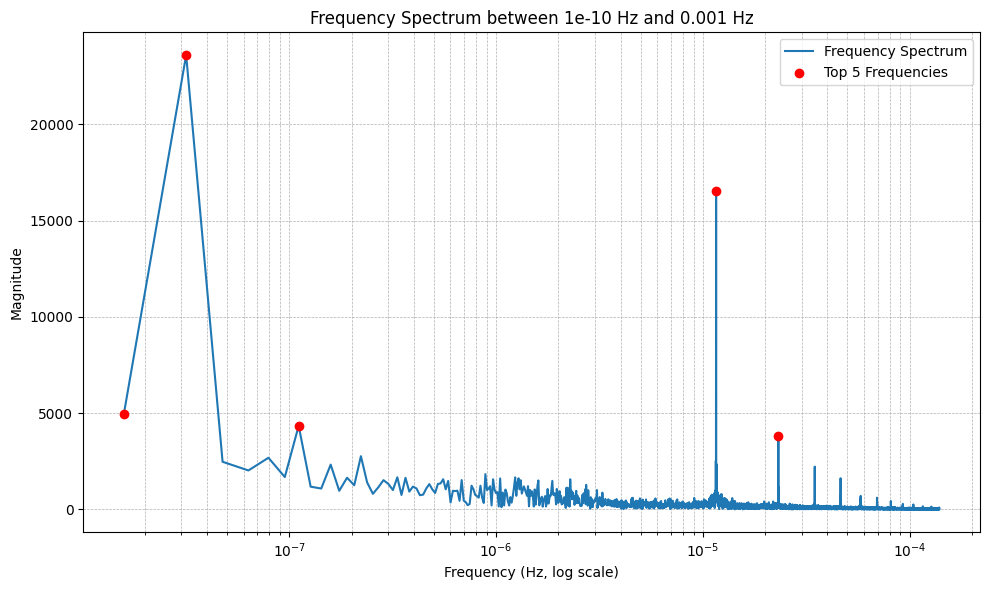

Top 5 frequencies with highest magnitude:
Frequency: 0.00000032 Hz, Period: 877.20 hours, Magnitude: 19679.4303
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 20601.4323
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 24961.0799
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 40168.7977
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 51108.7641


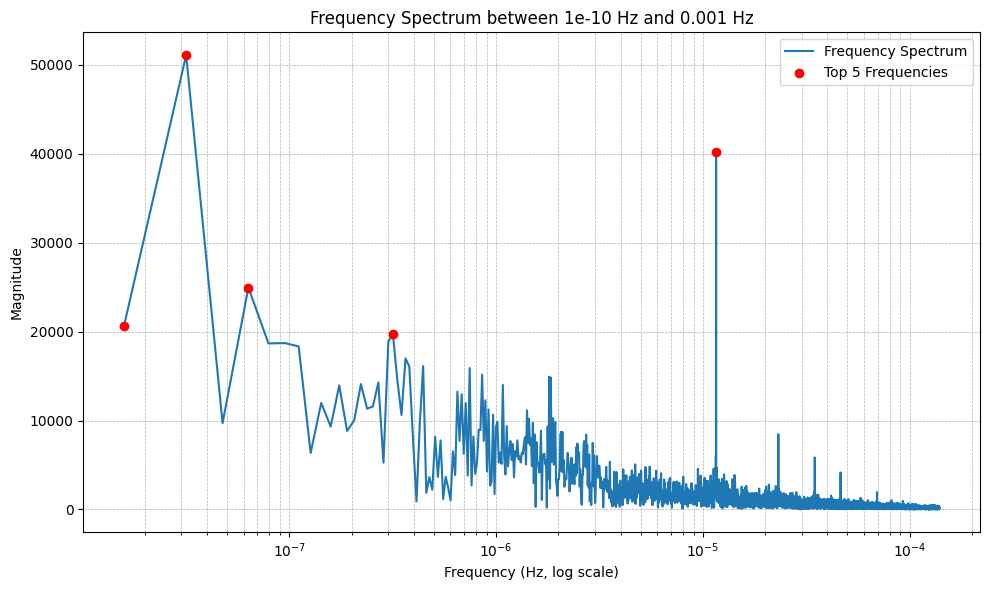

Top 5 frequencies with highest magnitude:
Frequency: 0.00000016 Hz, Period: 1754.40 hours, Magnitude: 6714.7006
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 7055.6813
Frequency: 0.00000009 Hz, Period: 2924.00 hours, Magnitude: 8461.5802
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 12095.7141
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 22231.6381


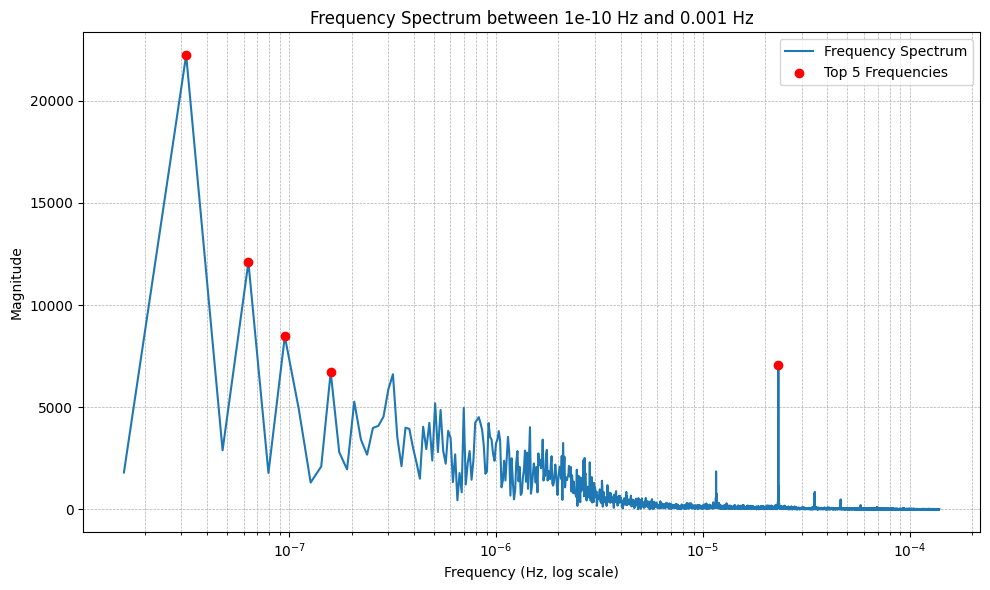

In [45]:
min_frequency = 10**-10
max_frequency = 10**-3
top_n = 5

plot_frequencies(dataframes["grafcan_cristianos"], "air_temperature", min_frequency, max_frequency, top_n, sampling_interval=3600)
plot_frequencies(dataframes["grafcan_cristianos"], "relative_humidity", min_frequency, max_frequency, top_n, sampling_interval=3600)
plot_frequencies(dataframes["grafcan_cristianos"], "atmospheric_pressure", min_frequency, max_frequency, top_n, sampling_interval=3600)

## Detección de outliers



In [46]:
def detect_outliers_iqr(df, threshold=1.5, return_indices=False):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    Optionally returns indices of the detected outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The multiplier for the IQR to determine outlier boundaries.
        return_indices (bool): If True, also return a dictionary of outlier indices for each column.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
        outlier_indices_dict (dict, optional): A dictionary containing outlier row indices for each numerical column.
    """
    outliers_dict = {}
    outlier_indices_dict = {}
    
    for column in df.select_dtypes(include=[np.number]).columns:
        # Calculate IQR-based bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        outlier_indices_dict[column] = outliers.index.tolist()
        
        # Create subplots for boxplot and histogram
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # Boxplot on the left with outliers highlighted
        ax1.boxplot(df[column], vert=False)
        ax1.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        ax1.set_title(f'Boxplot of {column}')  # Fixed typo here
        ax1.set_xlabel(column)
        ax1.legend()
        
        # Histogram on the right with bounds indicated
        ax2.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='Lower bound')
        ax2.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='Upper bound')
        ax2.set_title(f'Histogram of {column}')
        ax2.set_xlabel(column)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if return_indices:
        return outliers_dict, outlier_indices_dict
    return outliers_dict


Processing openmeteo_cristianos_arpege:


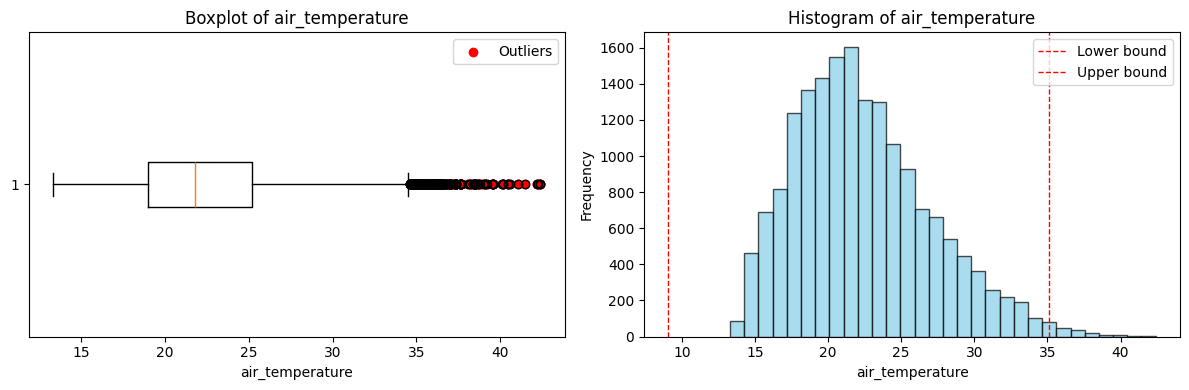

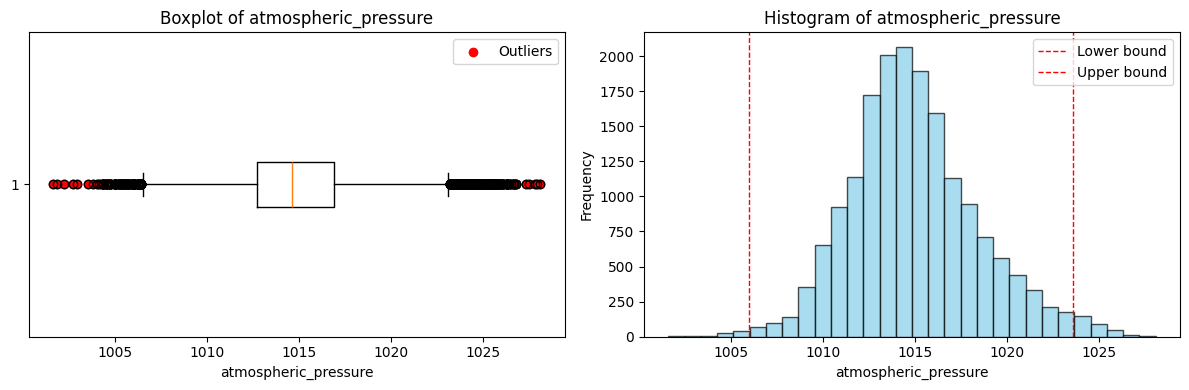

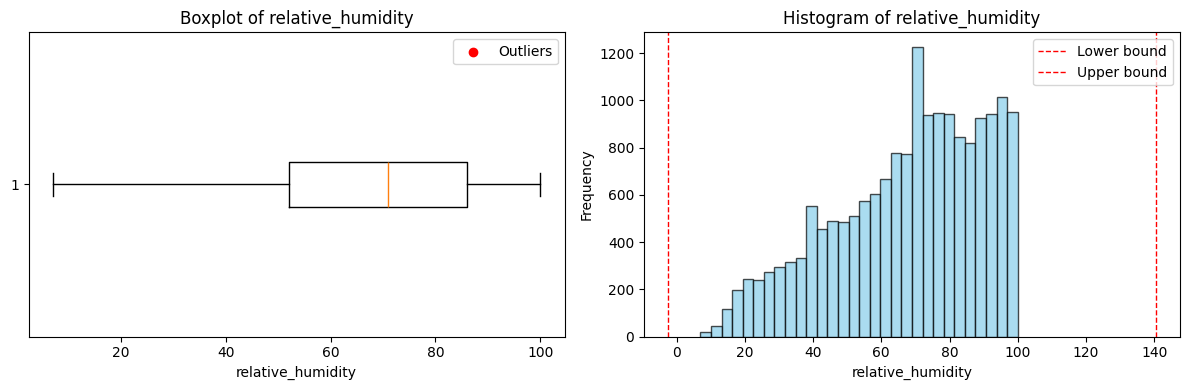

  air_temperature outlier row indices: [Timestamp('2023-06-28 13:00:00+0000', tz='UTC'), Timestamp('2023-06-28 14:00:00+0000', tz='UTC'), Timestamp('2023-06-28 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 16:00:00+0000', tz='UTC'), Timestamp('2023-06-28 17:00:00+0000', tz='UTC'), Timestamp('2023-06-28 18:00:00+0000', tz='UTC'), Timestamp('2023-06-28 19:00:00+0000', tz='UTC'), Timestamp('2023-07-04 15:00:00+0000', tz='UTC'), Timestamp('2023-07-11 11:00:00+0000', tz='UTC'), Timestamp('2023-07-11 14:00:00+0000', tz='UTC'), Timestamp('2023-07-11 17:00:00+0000', tz='UTC'), Timestamp('2023-07-12 12:00:00+0000', tz='UTC'), Timestamp('2023-07-12 15:00:00+0000', tz='UTC'), Timestamp('2023-07-12 16:00:00+0000', tz='UTC'), Timestamp('2023-07-12 18:00:00+0000', tz='UTC'), Timestamp('2023-07-12 19:00:00+0000', tz='UTC'), Timestamp('2023-07-13 09:00:00+0000', tz='UTC'), Timestamp('2023-07-13 11:00:00+0000', tz='UTC'), Timestamp('2023-07-13 12:00:00+0000', tz='UTC'), Timestamp('2023-07-13 13:00:0

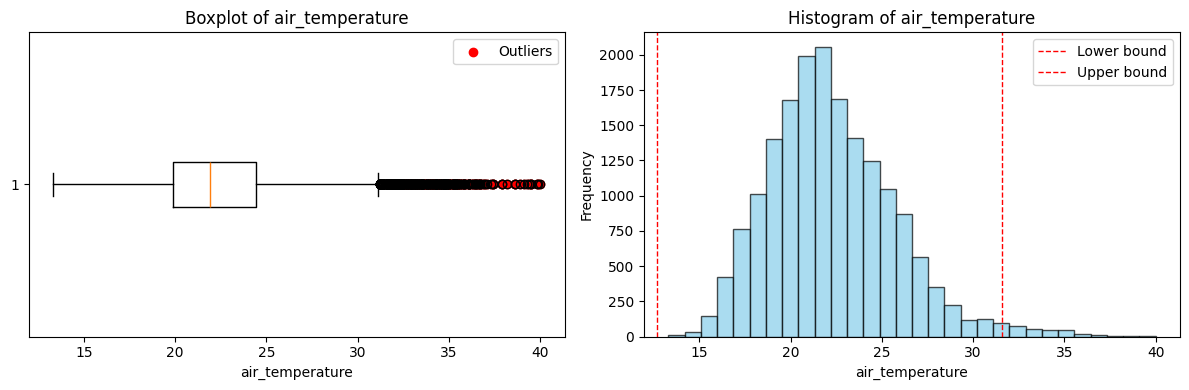

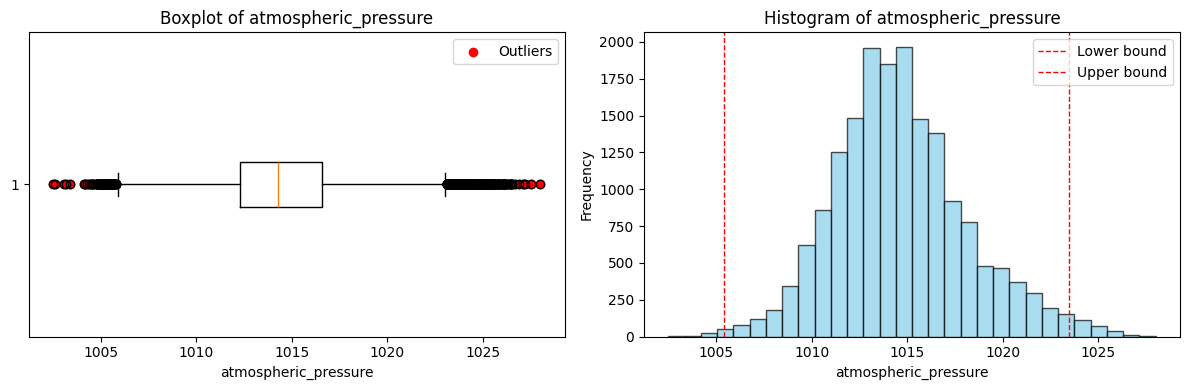

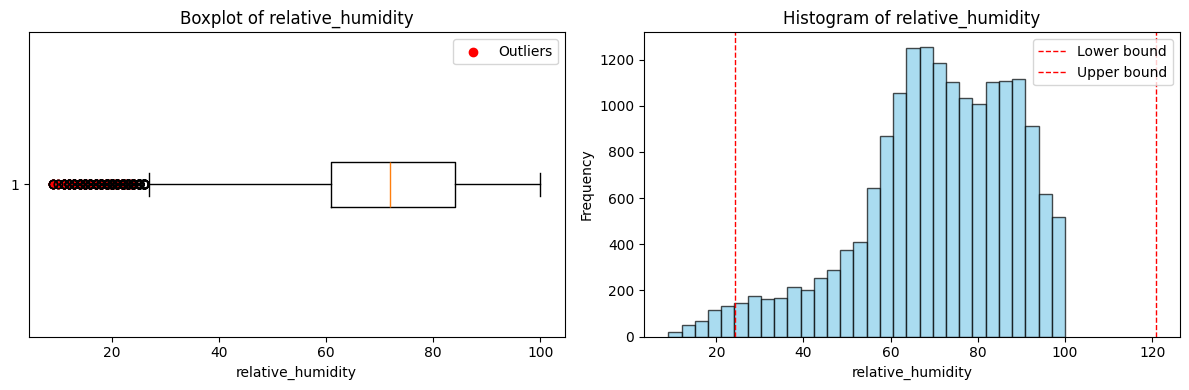

  air_temperature outlier row indices: [Timestamp('2023-03-26 12:00:00+0000', tz='UTC'), Timestamp('2023-03-26 13:00:00+0000', tz='UTC'), Timestamp('2023-03-27 14:00:00+0000', tz='UTC'), Timestamp('2023-03-27 15:00:00+0000', tz='UTC'), Timestamp('2023-03-27 16:00:00+0000', tz='UTC'), Timestamp('2023-03-29 12:00:00+0000', tz='UTC'), Timestamp('2023-03-29 13:00:00+0000', tz='UTC'), Timestamp('2023-03-29 14:00:00+0000', tz='UTC'), Timestamp('2023-03-29 15:00:00+0000', tz='UTC'), Timestamp('2023-03-29 16:00:00+0000', tz='UTC'), Timestamp('2023-03-30 09:00:00+0000', tz='UTC'), Timestamp('2023-03-30 10:00:00+0000', tz='UTC'), Timestamp('2023-03-30 11:00:00+0000', tz='UTC'), Timestamp('2023-03-30 12:00:00+0000', tz='UTC'), Timestamp('2023-03-30 13:00:00+0000', tz='UTC'), Timestamp('2023-03-30 14:00:00+0000', tz='UTC'), Timestamp('2023-03-30 15:00:00+0000', tz='UTC'), Timestamp('2023-03-30 16:00:00+0000', tz='UTC'), Timestamp('2023-03-30 17:00:00+0000', tz='UTC'), Timestamp('2023-03-30 18:00:0

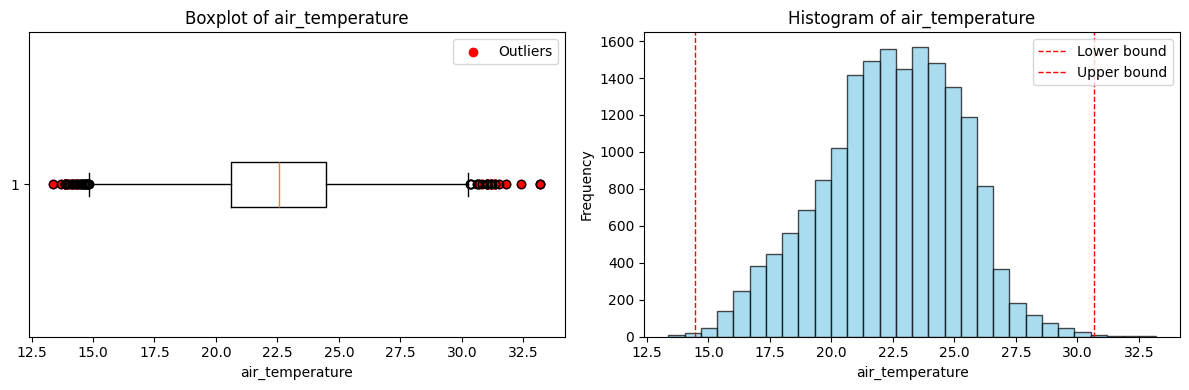

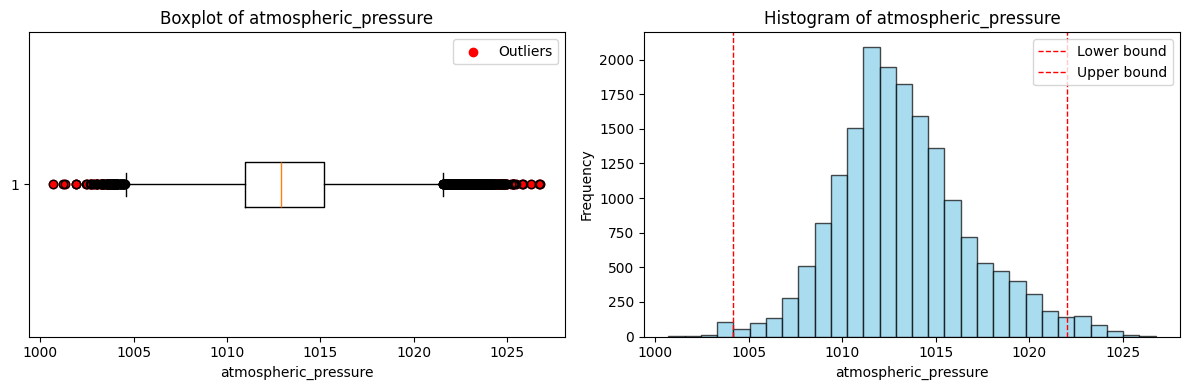

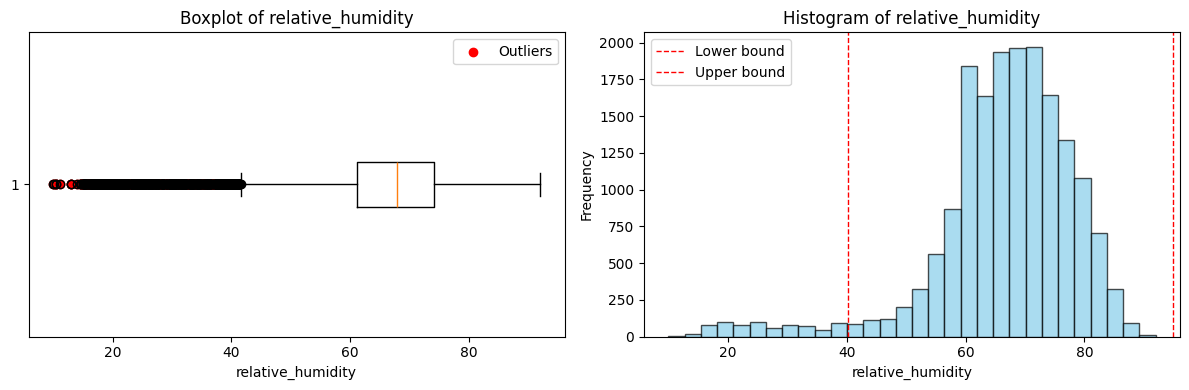

  air_temperature outlier row indices: [Timestamp('2023-08-20 11:00:00+0000', tz='UTC'), Timestamp('2023-08-21 14:00:00+0000', tz='UTC'), Timestamp('2023-08-26 00:00:00+0000', tz='UTC'), Timestamp('2023-08-26 01:00:00+0000', tz='UTC'), Timestamp('2023-08-26 13:00:00+0000', tz='UTC'), Timestamp('2023-08-26 14:00:00+0000', tz='UTC'), Timestamp('2023-11-20 12:00:00+0000', tz='UTC'), Timestamp('2023-11-20 13:00:00+0000', tz='UTC'), Timestamp('2023-11-20 14:00:00+0000', tz='UTC'), Timestamp('2023-11-20 15:00:00+0000', tz='UTC'), Timestamp('2024-04-03 09:00:00+0000', tz='UTC'), Timestamp('2024-04-03 10:00:00+0000', tz='UTC'), Timestamp('2024-04-03 11:00:00+0000', tz='UTC'), Timestamp('2024-04-03 12:00:00+0000', tz='UTC'), Timestamp('2024-04-03 13:00:00+0000', tz='UTC'), Timestamp('2024-04-03 14:00:00+0000', tz='UTC'), Timestamp('2024-04-03 15:00:00+0000', tz='UTC'), Timestamp('2024-04-03 16:00:00+0000', tz='UTC'), Timestamp('2024-04-03 17:00:00+0000', tz='UTC'), Timestamp('2024-11-08 17:00:0

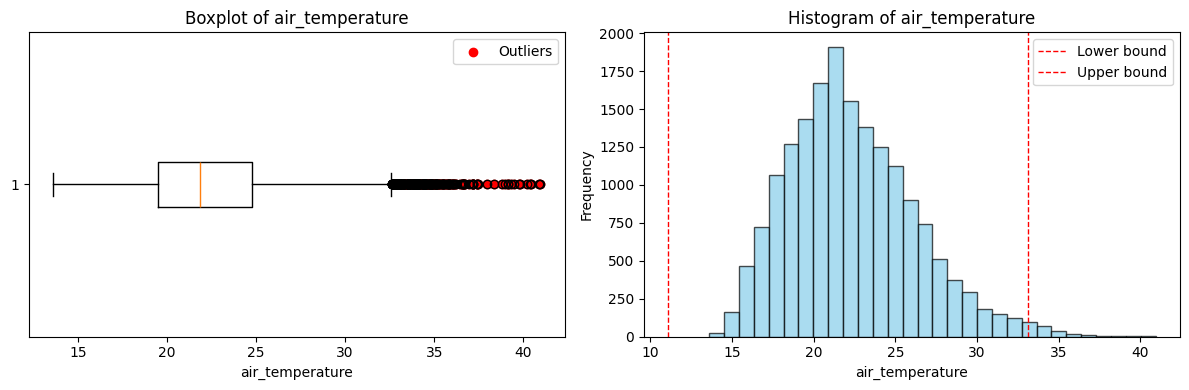

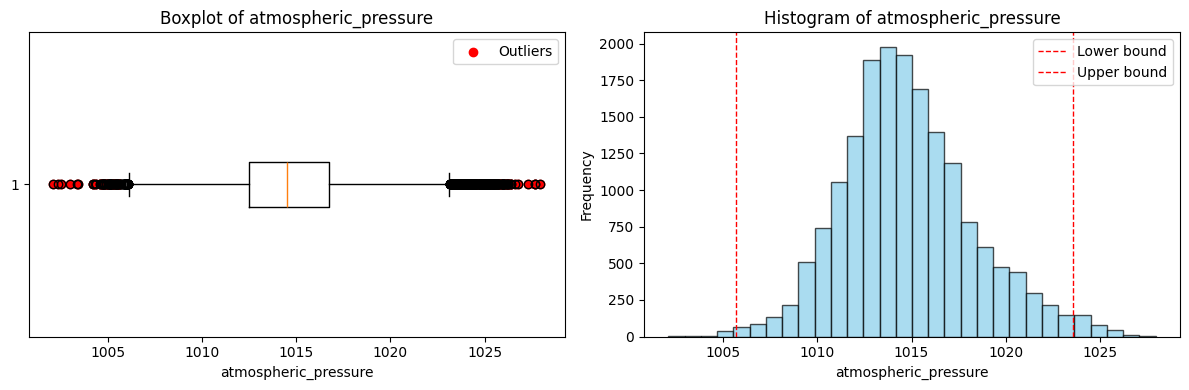

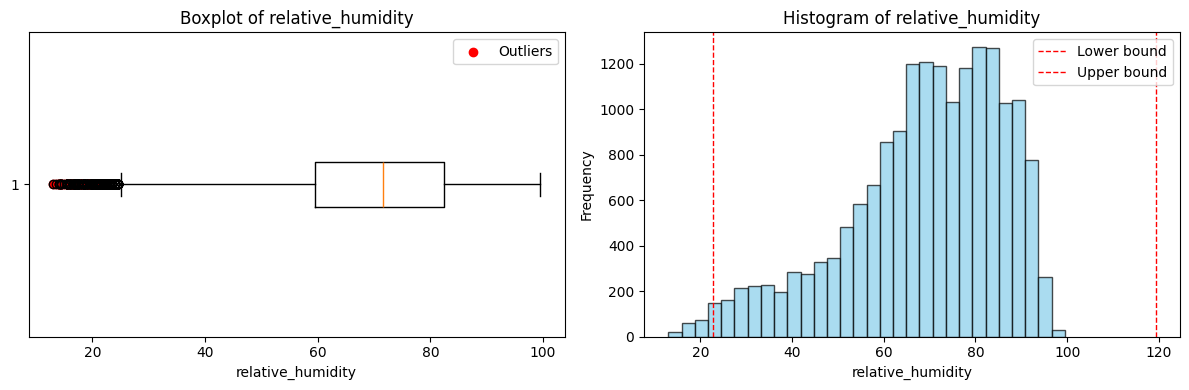

  air_temperature outlier row indices: [Timestamp('2023-03-30 11:00:00+0000', tz='UTC'), Timestamp('2023-03-30 12:00:00+0000', tz='UTC'), Timestamp('2023-03-30 13:00:00+0000', tz='UTC'), Timestamp('2023-03-30 14:00:00+0000', tz='UTC'), Timestamp('2023-03-30 15:00:00+0000', tz='UTC'), Timestamp('2023-03-30 16:00:00+0000', tz='UTC'), Timestamp('2023-03-30 17:00:00+0000', tz='UTC'), Timestamp('2023-03-30 18:00:00+0000', tz='UTC'), Timestamp('2023-03-31 13:00:00+0000', tz='UTC'), Timestamp('2023-03-31 14:00:00+0000', tz='UTC'), Timestamp('2023-06-28 13:00:00+0000', tz='UTC'), Timestamp('2023-06-28 14:00:00+0000', tz='UTC'), Timestamp('2023-06-28 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 16:00:00+0000', tz='UTC'), Timestamp('2023-06-28 17:00:00+0000', tz='UTC'), Timestamp('2023-06-28 18:00:00+0000', tz='UTC'), Timestamp('2023-07-11 14:00:00+0000', tz='UTC'), Timestamp('2023-07-11 17:00:00+0000', tz='UTC'), Timestamp('2023-07-12 12:00:00+0000', tz='UTC'), Timestamp('2023-07-12 13:00:0

In [47]:
threshold = 1.6

for file_key, df_hourly in dataframes.items():
    print(f"Processing {file_key}:")
    
    # Use the modified function to get both outlier values and their indices
    outliers, outlier_indices = detect_outliers_iqr(df_hourly, threshold, return_indices=True)
    
    # Print outliers for each column
    for column, indices in outlier_indices.items():
        print(f"  {column} outlier row indices: {indices}")
    
    # Combine all outlier indices from every column
    all_outlier_indices = set()
    for indices in outlier_indices.values():
        all_outlier_indices.update(indices)
    
    # Remove rows with any detected outlier
    df_clean = df_hourly.drop(list(all_outlier_indices))
    dataframes[file_key] = df_clean
    
    print(f"Removed {len(all_outlier_indices)} rows with outliers from {file_key}.\n")


## Escritura fichero 

In [48]:
for file_key, df_hourly in dataframes.items():
  print(df_hourly.describe())

       air_temperature  atmospheric_pressure  relative_humidity
count     17024.000000          17024.000000       17024.000000
mean         22.322250           1014.843715          67.802943
std           4.445794              3.204720          21.743176
min          13.300000           1006.000000           7.000000
25%          19.000000           1012.700000          53.000000
50%          21.800000           1014.600000          71.000000
75%          25.200000           1016.800000          86.000000
max          35.100000           1023.600000         100.000000
       air_temperature  atmospheric_pressure  relative_humidity
count     16663.000000          16663.000000       16663.000000
mean         22.060919           1014.479451          71.871212
std           3.097204              3.239243          16.071339
min          13.300000           1005.500000          25.000000
25%          19.900000           1012.300000          62.000000
50%          21.900000           1014.30